In [12]:
import itertools
import pickle
import numpy as np
from scipy.io.matlab import loadmat
from sklearn.metrics import mean_squared_error, roc_auc_score
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from collections import defaultdict

from almc.bayesian_rescal import PFBayesianRescal, PFBayesianCompRescal, PFBayesianLogitRescal

%matplotlib inline

In [123]:
color = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(color)):    
    r, g, b = color[i]    
    color[i] = (r / 255., g / 255., b / 255.)
    
markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd')

model_colors = {'brescal':color[0], 'amdc_pop':color[8], 'amdc_pred':color[7], 
                'bcomp_mul':color[2], 'bcomp_add':color[3], 'logit':color[5], 
                'rescal':'grey',
                'brescal_passive':'grey', 'bcomp_mul_10': color[8], 'bcomp_add_10':color[9], 
                'bcomp_mul_comp_10':color[11], 'bcomp_add_comp_10':color[13], 
                'bcomp_mul_var_1_comp_10': color[15], 'bcomp_add_var_1_comp_10': color[17]}
model_names = {'rescal':'rescal', 'brescal':'pnormal', 'amdc_pop':'amdc_pop', 'amdc_pred':'amdc_pred', 
               'bcomp_mul':'pcomp-mul', 'bcomp_add':'pcomp-add', 'logit':'plogit', 
               'brescal_passive':'brescal_passive'}    

In [2]:
def load_dataset(dataset):
    if dataset == 'umls':
        mat = loadmat('../data/%s/uml.mat' % (dataset))
        T = np.array(mat['Rs'], np.float32)
    elif dataset == 'nation':
        mat = loadmat('../data/%s/dnations.mat' % (dataset))
        T = np.array(mat['R'], np.float32)
    elif dataset == 'kinship':
        mat = loadmat('../data/%s/alyawarradata.mat' % (dataset))
        T = np.array(mat['Rs'], np.float32)
    elif dataset == 'wordnet':
        T = pickle.load(open('../data/%s/reduced_wordnet.pkl' % (dataset), 'rb'))
    elif dataset == 'freebase':
        T, _, _ = pickle.load(open('../data/freebase/subset_5000.pkl', 'rb'))

    if dataset == 'umls' or dataset == 'nation' or dataset == 'kinship':
        T = np.swapaxes(T, 1, 2)
        T = np.swapaxes(T, 0, 1)  # [relation, entity, entity]
        T[np.isnan(T)] = 0
    return T

In [3]:
dataset = 'umls'
mat = loadmat('../data/%s/uml.mat' % (dataset))
T = load_dataset(dataset)
mat.keys()

dict_keys(['Rs', 'names', '__globals__', 'relnames', 'gnames', '__header__', '__version__'])

In [4]:
rel_names = {i:rel[0][0] for i, rel in enumerate(mat['relnames'])}

In [32]:
entity_names = {i:name[0][0] for i, name in enumerate(mat['names'])}
print(entity_names)

{0: 'Acquired_Abnormality', 1: 'Activity', 2: 'Age_Group', 3: 'Alga', 4: 'Amino_Acid,_Peptide,_or_Protein', 5: 'Amino_Acid_Sequence', 6: 'Amphibian', 7: 'Anatomical_Abnormality', 8: 'Anatomical_Structure', 9: 'Animal', 10: 'Antibiotic', 11: 'Archaeon', 12: 'Bacterium', 13: 'Behavior', 14: 'Biologic_Function', 15: 'Biologically_Active_Substance', 16: 'Biomedical_Occupation_or_Discipline', 17: 'Biomedical_or_Dental_Material', 18: 'Bird', 19: 'Body_Location_or_Region', 20: 'Body_Part,_Organ,_or_Organ_Component', 21: 'Body_Space_or_Junction', 22: 'Body_Substance', 23: 'Body_System', 24: 'Carbohydrate', 25: 'Carbohydrate_Sequence', 26: 'Cell', 27: 'Cell_Component', 28: 'Cell_Function', 29: 'Cell_or_Molecular_Dysfunction', 30: 'Chemical', 31: 'Chemical_Viewed_Functionally', 32: 'Chemical_Viewed_Structurally', 33: 'Classification', 34: 'Clinical_Attribute', 35: 'Clinical_Drug', 36: 'Conceptual_Entity', 37: 'Congenital_Abnormality', 38: 'Daily_or_Recreational_Activity', 39: 'Diagnostic_Procedu

In [99]:
models = ['brescal', 'bcomp_mul', 'bcomp_add', 'logit']
p = 0.1

E = dict()
R = dict()
test_msk = pickle.load(open('../result_tt/umls/test.pkl', 'rb'))
train_msk = pickle.load(open('../result_tt/umls/%.2f_train.pkl' % p, 'rb'))
trainT = np.zeros_like(T)
trainT[train_msk==1] = T[train_msk==1]

for model in models:
    E[model] = pickle.load(open('../result_tt/umls/E_%s_%.2f.pkl' % (model, p), 'rb'))
    R[model] = pickle.load(open('../result_tt/umls/R_%s_%.2f.pkl' % (model, p), 'rb'))

In [193]:
n_relation, n_entity, _ = T.shape

rnd = np.random.RandomState(seed=2345)

score = defaultdict(float)
cnt = defaultdict(float)
score_second = defaultdict(float)
cnt2 = defaultdict(float)
score_third = defaultdict(float)
cnt3 = defaultdict(float)
score_forth = defaultdict(float)
    
cap=10
cap2 = 10
idx1 = np.arange(n_relation)
idx2 = np.arange(n_relation)
idx3 = np.arange(n_relation)
idx4 = np.arange(n_relation)
rnd.shuffle(idx1)
rnd.shuffle(idx2)
rnd.shuffle(idx3)
rnd.shuffle(idx4)

for model in models:
    recT = np.zeros_like(T)
    for k in range(n_relation):
        recT[k] = np.dot(np.dot(E[model], R[model][k]), E[model].T)
    score[model] = roc_auc_score(T[test_msk==1], recT[test_msk==1])
    
    recT = np.zeros([n_relation**2, n_entity, n_entity])
    T2 = np.zeros([n_relation**2, n_entity, n_entity], dtype=np.int)
    for i, (k, k2) in enumerate(itertools.product(range(n_relation), repeat=2)):
        recT[i] = np.dot(np.dot(np.dot(E[model], R[model][k]), R[model][k2]), E[model].T)
        T2[i] = np.dot(T[k], T[k2])
    T2[T2 > 1] = 1
    score_second[model] = roc_auc_score(T2.flatten(), recT.flatten())

    recT = np.zeros([cap**3, n_entity, n_entity])
    T3 = np.zeros([cap**3, n_entity, n_entity], dtype=np.int)
    
    for i, (k, k2, k3) in enumerate(itertools.product(idx1[:cap], idx2[:cap], idx3[:cap])):
        recT[i] = np.dot(np.dot(np.dot(np.dot(E[model], R[model][k]), R[model][k2]), R[model][k3]), E[model].T)
        T3[i] = np.dot(np.dot(T[k], T[k2]), T[k3])
    T3[T3 > 1] = 1
    if len(np.unique(T3)) > 1:
        score_third[model] = roc_auc_score(T3.flatten(), recT.flatten())

    recT = np.zeros([cap2**4, n_entity, n_entity])
    T4 = np.zeros([cap2**4, n_entity, n_entity], dtype=np.int)
    
    for i, (k, k2, k3, k4) in enumerate(itertools.product(idx1[:cap2], idx2[:cap2], idx3[:cap2], idx4[:cap2])):
        recT[i] = np.dot(np.dot(np.dot(np.dot(np.dot(E[model], R[model][k]), R[model][k2]), R[model][k3]),R[model][k4]), E[model].T)
        T4[i] = np.dot(np.dot(np.dot(T[k], T[k2]), T[k3]),T[k4])
    T4[T4 > 1] = 1
    if len(np.unique(T4)) > 1:
        score_forth[model] = roc_auc_score(T4.flatten(), recT.flatten())        

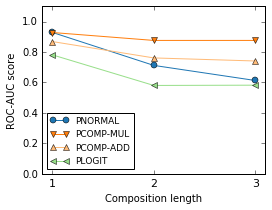

In [146]:
legend_size=9
font_size=11

plt.figure()
fig, ax = plt.subplots(figsize=(4,3))
for model in models:
    c = model_colors[model]
    plt.plot([score[model], score_second[model], score_third[model]], marker=markers[models.index(model)], color=c, label=model_names[model].upper())
plt.legend(loc='lower left', prop={'size':legend_size})
plt.xticks([0,1,2], [1,2,3], size=font_size)
plt.xlabel('Composition length')
plt.ylabel('ROC-AUC score')
plt.xlim([-0.1,2.1])
plt.ylim([0,1.1])
plt.savefig('../paper/cikm2016/images/path_prediction.pdf', format='PDF', bbox_inches='tight', pad_inches=0.1)

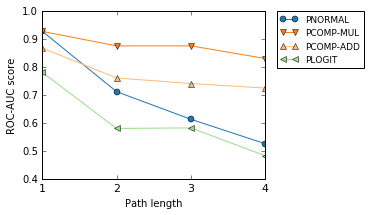

In [198]:
legend_size=9
font_size=11

plt.figure()
fig, ax = plt.subplots(figsize=(4,3))
for model in models:
    c = model_colors[model]
    plt.plot([score[model], score_second[model], score_third[model], score_forth[model]], marker=markers[models.index(model)], color=c, label=model_names[model].upper())
#plt.legend(loc='lower left', prop={'size':legend_size})
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size':legend_size})
plt.xticks([0,1,2,3], [1,2,3,4], size=font_size)
plt.xlabel('Path length')
plt.ylabel('ROC-AUC score')
plt.savefig('../paper/cikm2016/images/path_prediction2.pdf', format='PDF', bbox_inches='tight', pad_inches=0.1)

## Path prediction example

In [76]:
rel2 = 41
rel1 = 1

e_start =87
abnormality = [0,7,37]
procedures = [39, 78, 130]

In [181]:
score = defaultdict(float)
score2 = defaultdict(float)
first_step = defaultdict(list)
second_step = defaultdict(list)

for model in models:
    rec = np.dot(np.dot(E[model][e_start], R[model][rel1]), E[model].T)
    score[model] = roc_auc_score(T[rel1,e_start,:], rec)
    
    rec2 = np.dot(np.dot(np.dot(E[model][e_start], R[model][rel1]), R[model][rel2]), E[model].T)
    T2 = np.dot(T[rel1,e_start,:], T[rel2]) 
    T2[T2>1]=1
    if len(np.unique(T2)) > 1:
        score2[model] = roc_auc_score(T2, rec2)
        
    sorted_idx = rec.argsort()[::-1]
    for i in range(5):
        if T[rel1,e_start,sorted_idx[i]] == 1:
            first_step[model].append('\\textbf{%s}' % entity_names[sorted_idx[i]])
        else:
            first_step[model].append(entity_names[sorted_idx[i]])
            
    sorted_idx2 = rec2.argsort()[::-1]
    for i in range(5):
        if T2[sorted_idx2[i]] == 1:
            second_step[model].append('\\textbf{%s}' % entity_names[sorted_idx2[i]])
        else:
            second_step[model].append(entity_names[sorted_idx2[i]])

In [186]:
for model in models:
    print(model, '&', '&'.join(first_step[model]).replace('_','-'), '\\\\')

brescal & \textbf{Invertebrate}&\textbf{Reptile}&\textbf{Archaeon}&\textbf{Bird}&\textbf{Physiologic-Function} \\
bcomp_mul & \textbf{Archaeon}&\textbf{Fish}&\textbf{Fungus}&\textbf{Invertebrate}&\textbf{Human} \\
bcomp_add & \textbf{Pathologic-Function}&\textbf{Bird}&\textbf{Cell-or-Molecular-Dysfunction}&Drug-Delivery-Device&Congenital-Abnormality \\
logit & \textbf{Cell-Function}&\textbf{Disease-or-Syndrome}&\textbf{Cell-or-Molecular-Dysfunction}&\textbf{Experimental-Model-of-Disease}&\textbf{Mental-Process} \\


In [187]:
for model in models:
    print(model, '&', '&'.join(second_step[model]).replace('_','-'), '\\\\')

brescal & Clinical-Drug&Sign-or-Symptom&Organism-Attribute&Drug-Delivery-Device&Clinical-Attribute \\
bcomp_mul & \textbf{Enzyme}&\textbf{Body-Substance}&\textbf{Neuroreactive-Substance-or-Biogenic-Amine}&Carbohydrate&\textbf{Immunologic-Factor} \\
bcomp_add & \textbf{Immunologic-Factor}&\textbf{Body-Substance}&Molecular-Biology-Research-Technique&Clinical-Drug&Chemical-Viewed-Structurally \\
logit & Amphibian&Governmental-or-Regulatory-Activity&Food&Biologic-Function&Classification \\


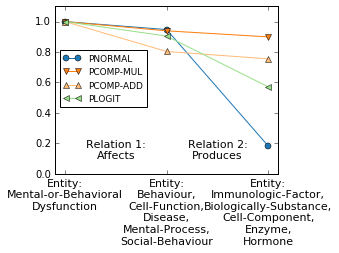

In [134]:
legend_size=9
font_size=11

plt.figure()
fig, ax = plt.subplots(figsize=(4,3))
for model in models:
    c = model_colors[model]
    plt.plot([1, score[model], score2[model]], marker=markers[models.index(model)], color=c, label=model_names[model].upper())
plt.legend(loc=(0.02,0.4), prop={'size':legend_size})
entity = 'Entity:\nMental-or-Behavioral\nDysfunction'
entity1 = 'Entity:\nBehaviour,\nCell-Function,\nDisease,\nMental-Process,\nSocial-Behaviour'
entity2 = 'Entity:\nImmunologic-Factor,\nBiologically-Substance,\nCell-Component,\nEnzyme,\nHormone'
ax.annotate('Relation 1:\nAffects', xy=(0.5,0.1), horizontalalignment='center', size=font_size)
ax.annotate('Relation 2:\nProduces', xy=(1.5,0.1), horizontalalignment='center', size=font_size)
plt.xticks([0,1,2], [entity,entity1,entity2], size=font_size)
plt.xlim([-0.1,2.1])
plt.ylim([0,1.1])
plt.savefig('../paper/cikm2016/images/path_reconstruction.pdf', format='PDF', bbox_inches='tight', pad_inches=0.1)